# CH08


## 08-3 합성곱 신경망의 시각화
`가중치 시각화` `특성 맵 시각화` `함수형 API`

## 가중치 시각화
- 합성곱 층은 여러 개의 필터를 사용하여 입력 이미지에서 특징을 추출
- 각 필터는 입력 이미지에 적용되어 특징맵을 만듦
- 필터는 시각적으로 '가중치'로 해석되며, 특정 특징을 감지하는 역할

동일한 이미지를 필터로 처리할 경우, 특정 부분은 강하게 활성화되고 나머지 부분은 그렇지 않게 나타난다.   
→ 특정 특징에 집중된 값을 가지게 됨.


In [ ]:
from tensorflow import keras

In [ ]:
!wget https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.keras

--2024-08-06 07:29:58--  https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.keras
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.keras [following]
--2024-08-06 07:29:59--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4038273 (3.9M) [application/octet-stream]
Saving to: ‘best-cnn-model.keras’

best-cnn-model.kera 100%[===================>]   3.85M  --.-KB/s    in 0.04s   

2024-08-06 07:30:00 (96.7 MB/s) - ‘best-cnn-model.keras’ saved [4038273/4038273]



In [ ]:
model = keras.models.load_model('best-cnn-model.keras')

In [ ]:
model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [ ]:
# 모델의 첫 번째 층(conv layer)의 weights를 불러와서 shape을 확인하고 가중치가 32개의 (3,3,1) 필터로 구성되어 있음을 확인

conv = model.layers[0]

print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()

print(conv_weights.mean(), conv_weights.std())

-0.014383553 0.23351653


In [ ]:
import matplotlib.pyplot as plt

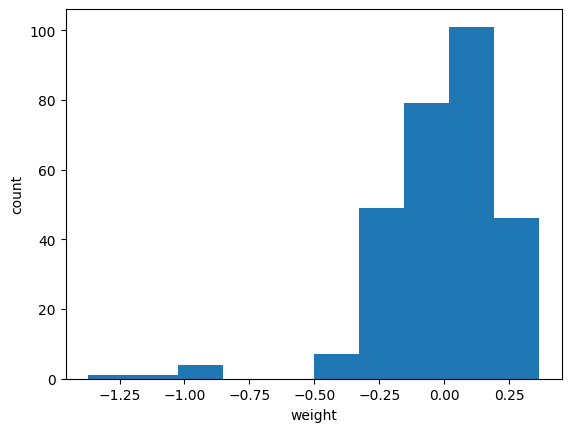

In [ ]:
# weights[0]의 평균(mean)과 표준편차(std)를 출력하여 분포를 파악하고, 히스토그램으로 시각화
# 훈련된 모델의 경우 평균 0에 가까운 정규분포 형태를 보임->가중치 초기화가 잘 되고 학습이 정상적으로 이루어졌음을 의미
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

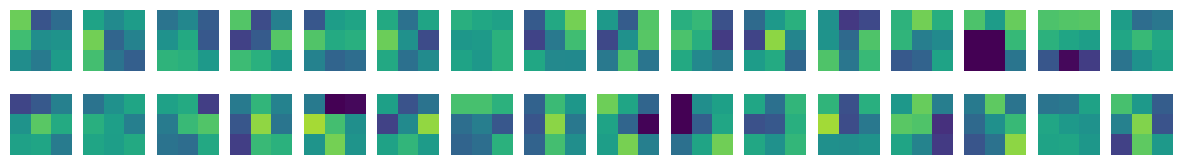

In [ ]:
# 필터별 시각화는 subplot을 활용해 2행 16열로 구성
# imshow()를 통해 필터 가중치의 시각적 구조 확인 가능

fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

In [ ]:
# 훈련 전/후 가중치 비교

no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

0.0053191613 0.08463709


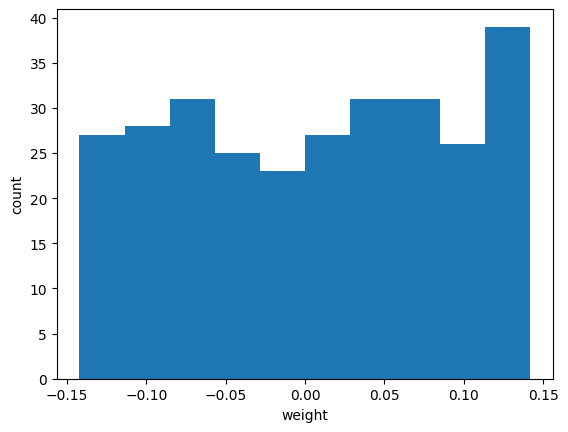

In [ ]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

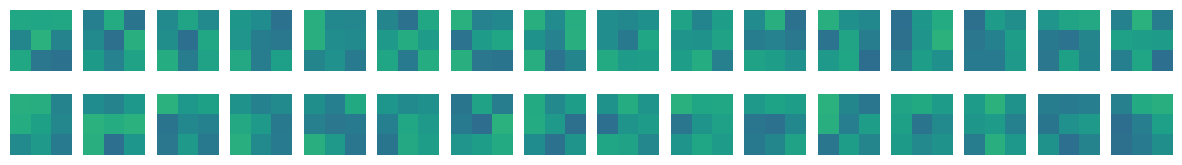

In [ ]:
# 히스토그램과 imshow를 통해 가중치 분포와 시각적 차이를 직관적으로 비교함
# 학습 전: 무작위성 큼, 특정한 패턴 없음
# 학습 후: 패턴이 뚜렷하고 특정 feature에 반응하도록 구조화됨

fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

## 함수형 API

- 함수형 API는 Sequential보다 유연하게 모델을 설계할 수 있음
- 특히 분기, 병합 등의 복잡한 구조를 구성할 때 유리

- Dense 층을 따로 정의한 후, 중간에 연결된 흐름대로 모델을 구성할 수 있음
- 입력 → 은닉층 → 출력층 → Model(inputs, outputs)로 최종 모델 정의
- 함수형 API에서는 명시적으로 keras.Input()으로 입력 정의 필요


In [ ]:
print(model.inputs)

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=input_layer>]


In [ ]:
conv_acti = keras.Model(model.inputs, model.layers[0].output)

## 특성 맵 시각화

In [ ]:
# fashion MNIST 이미지 로드 후 첫 번째 샘플 선택
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


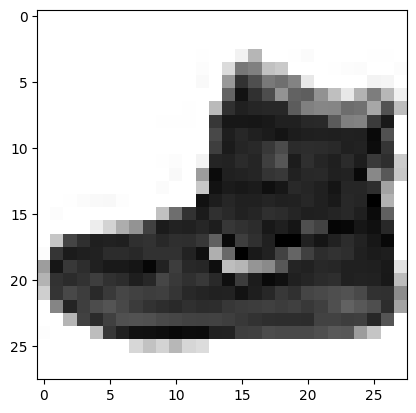

In [ ]:
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [ ]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1)/255.0

feature_maps = conv_acti.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
print(feature_maps.shape)

(1, 28, 28, 32)


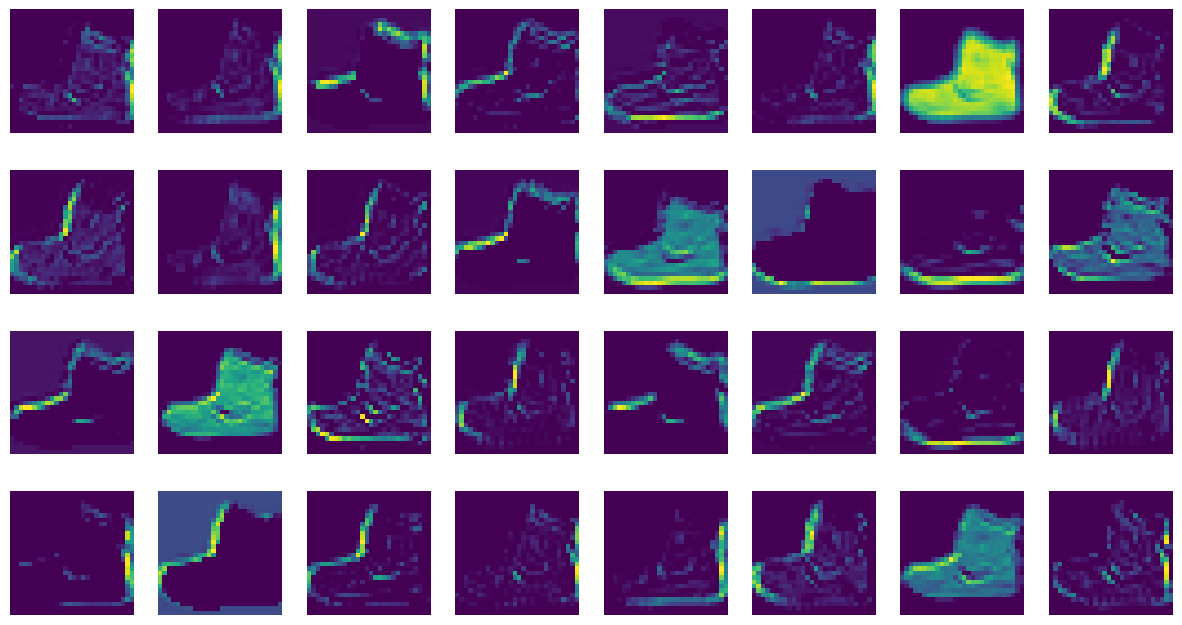

In [ ]:
fig, axs = plt.subplots(4, 8, figsize=(15,8))

for i in range(4):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

In [ ]:
# model.layers[2]의 출력을 사용해 conv2_acti 모델을 생성

conv2_acti = keras.Model(model.inputs, model.layers[2].output)

In [ ]:
feature_maps = conv2_acti.predict(train_input[0:1].reshape(-1, 28, 28, 1)/255.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


In [ ]:
print(feature_maps.shape)

(1, 14, 14, 64)


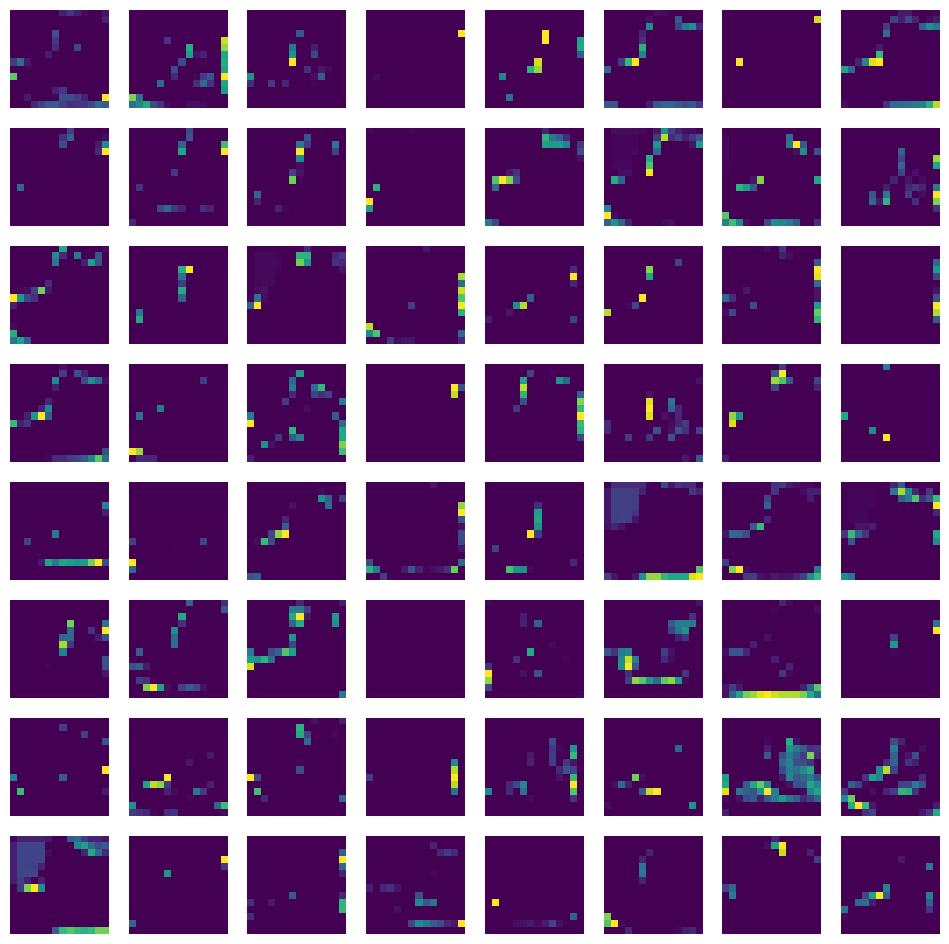

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(12,12))

for i in range(8):
    for j in range(8):
        axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
        axs[i, j].axis('off')

plt.show()

## 확인 문제

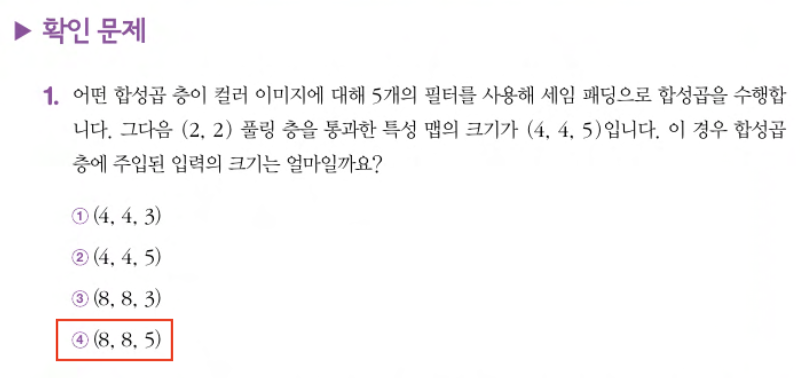

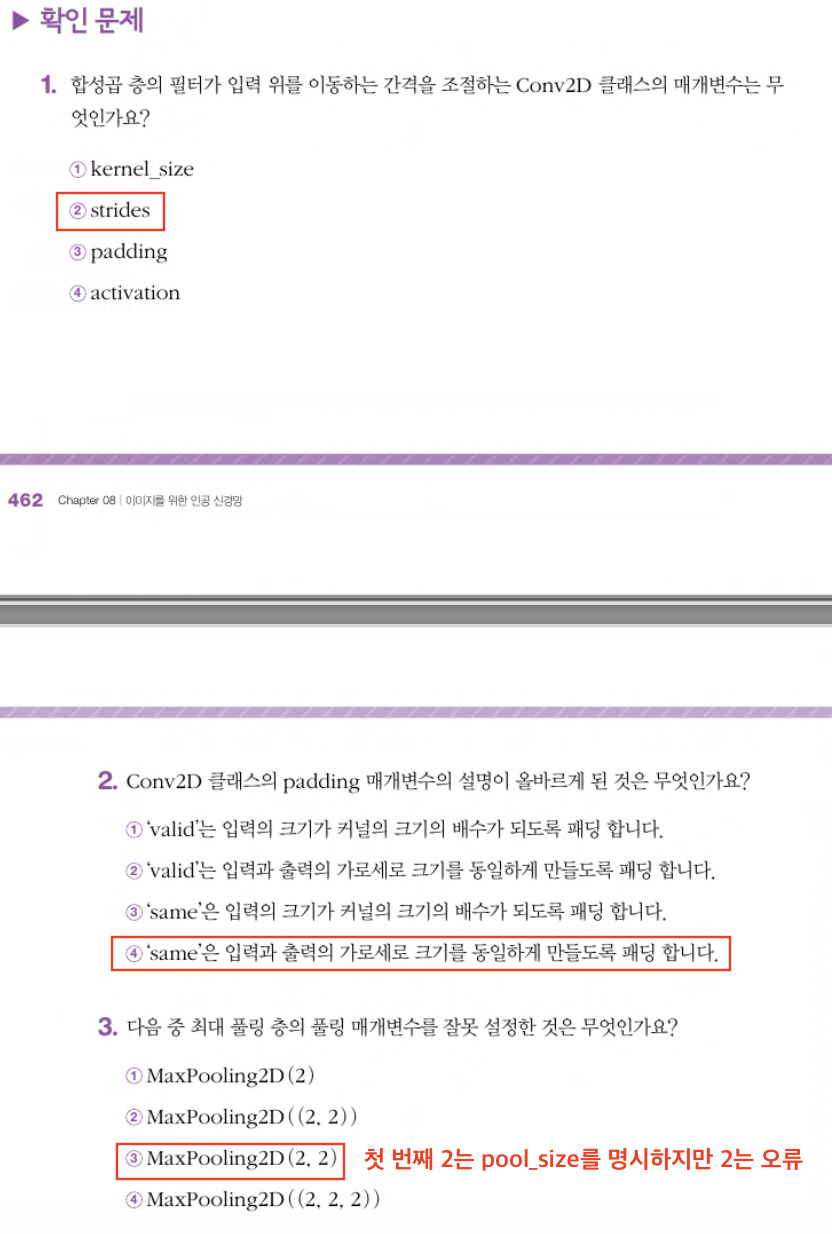

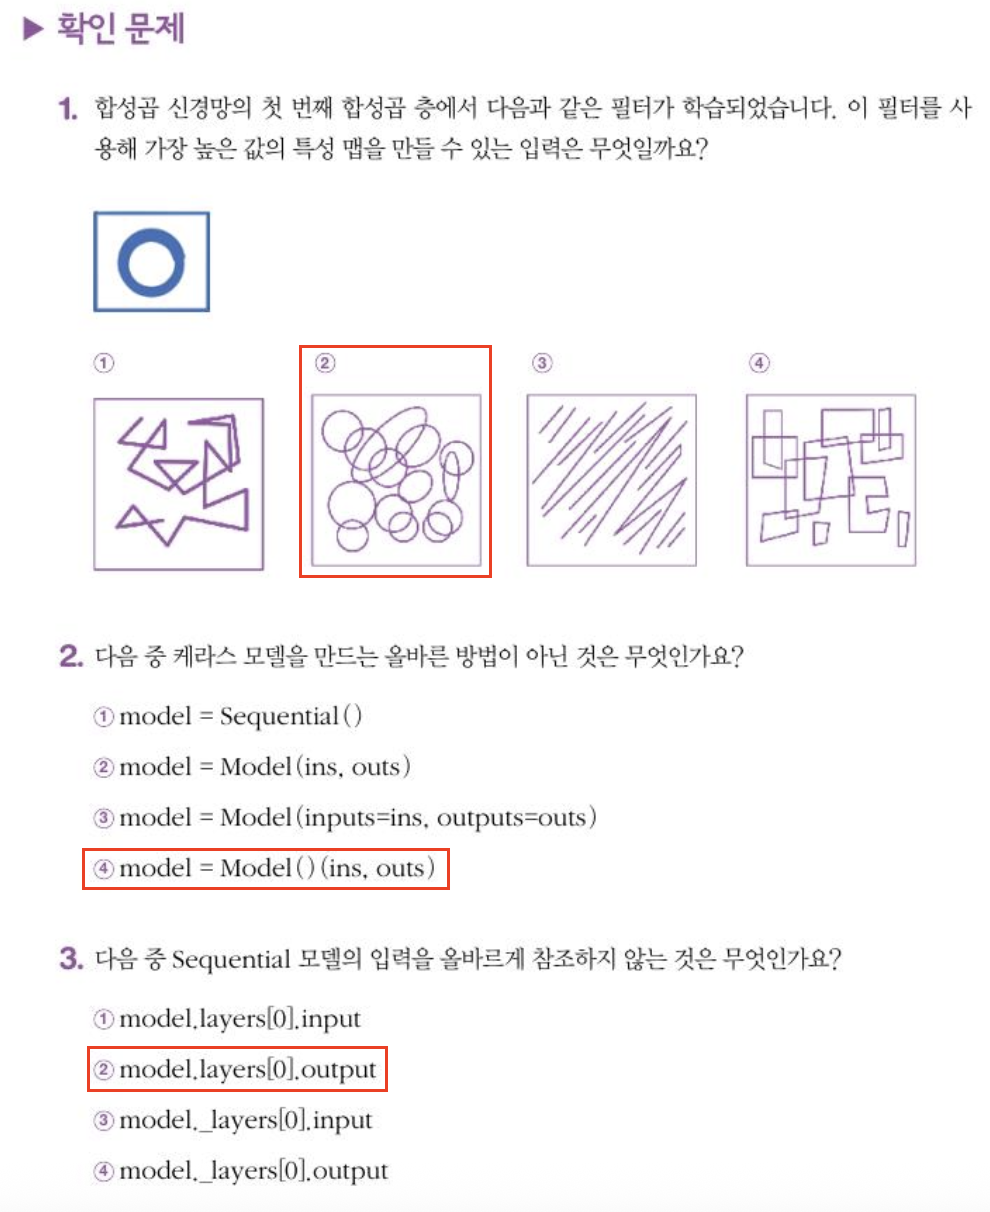